# Genome Sequencing
Authors:  
- Minh Duc Ngo  
- Catharina Hoppensack  

This notebook is our own work. Any other sources have been clearly marked and cited.

All authors contributed equally.

## 1 Environment
We worked with the following environment for this jupyter notebook:

- Python version: (3.10.19) 3.11.9  
- OS: Windows 11  
- Environment: Visual Studio Code

In [1]:
#install all basic libraries
%pip install matplotlib pandas numpy scikit-learn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

To be able to run this code on a device with GPU and CPU, the following code block is necessary.

In [3]:
#detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2 Data Loading and Inspection

First, we print general information about our dataset. The head() function shows us 2 columns and the first 5 rows from which we get a good first impression of how the data frame is structured. In the sequence column, we see 10 letters composed of A,C,G,T representing the four organic bases (Adenosine, Cytosine, Guanine, Thymine), that make up the genetic information in the DNA. The label column shows only zeros, which indicates we may need some more information.  

To get more insights about the sample count, any null entries, which data type we are dealing with and the amount of memory consumption, we used the info() function. 


In [4]:
url="https://github.com/thomasmanke/DataSets/raw/refs/heads/main/labeled_sequences.csv.gz"

df = pd.read_csv(url)

display(df.head())

df.info()
print(type(df["sequence"][0]))

,sequence,label
0,GTAGGTAAGC,0
1,GGGGTATTTG,0
2,CACTTCCCTT,0
3,AATCCATAAG,0
4,GGCTTTTGCC,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  20000 non-null  object
 1   label     20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB
<class 'str'>


The data frame contains 20,000 samples, each sequence consisting of ten letters composed of A, C, G, and T, and containing no zero values.
The sequences are objects and the labels are integers. The values in the column are stored as strings. Pandas shows the column as having dtype object unless the dedicated StringDtype is enabled. By calling print(type(df["sequence"][0])), we can verify that the first entry is indeed a string.

When we simply print the dataframe, we see the first and last 5 entries and the dimensions at the end. Here we see that label can also have the value 1. To check what values we have exactly in the label column, we used the unique() function. There are only zeroes and ones.  
To be sure that the dimensions are truly correct, we used the df.ndim() function, which outputs the dimensions of the data frame.

In [5]:
print(df)
print("\n")
print("Unique labels: ", df['label'].unique()) #https://note.nkmk.me/en/python-pandas-value-counts/
print("\n")
print(df.ndim) #dimensionen des DataFrames


         sequence  label
0      GTAGGTAAGC      0
1      GGGGTATTTG      0
2      CACTTCCCTT      0
3      AATCCATAAG      0
4      GGCTTTTGCC      0
...           ...    ...
19995  GGGGTGAGAG      0
19996  ACCGCGACTA      0
19997  TCCTGCGAAT      0
19998  GATGCAGGCT      0
19999  ATCATTACGT      1

[20000 rows x 2 columns]


Unique labels:  [0 1]


2


To prevent data leakage, bias, and overfitting, we remove duplicates.  
We then store the sequences in a list and save both the number of sequences and their lengths in separate variables.  
In addition, we check whether there are different lengths in the sequence entries.  
After removing duplicates the count of samples reduced to 19797.

In [6]:
df_noDuplicates = df.drop_duplicates() #remove duplicate sequences
seqs = df_noDuplicates["sequence"].tolist()
y    = df_noDuplicates["label"].values
S = len(seqs)    # number of sequences
L = len(seqs[0]) # same length for all (!!!) sequences

assert all(len(s) == L for s in seqs), "different lenghts detected" #check if there are errors in sequence length 

print(len(df_noDuplicates))


19797


### 3 Data Processing

A neural network is not able to calculate with letters, therefore we must assign an integer to each letter. The print outputs show the letter version compared to the integer version and the data types used.

In [7]:
#sequence to number conversion, ACGT -> 1234
mapping = str.maketrans({'A':'1','C':'2','G':'3','T':'4'})

seqs_num = [] #new list for numbers
for seq in seqs:
    mapped = seq.translate(mapping)       #"ACGT" -> "1234"
    nums = [int(x) for x in mapped]       #-> [1,2,3,4]
    seqs_num.append(nums)

In [8]:
print(seqs[0:5]) #print first 5 elements of sequence in letters
print(type(seqs))
print(type(seqs[0][0]))
print(seqs_num[0:5]) #print first 5 elelments of sequence in numbers
print(type(seqs_num))
print(type(seqs_num[0][0]))

['GTAGGTAAGC', 'GGGGTATTTG', 'CACTTCCCTT', 'AATCCATAAG', 'GGCTTTTGCC']
<class 'list'>
<class 'str'>
[[3, 4, 1, 3, 3, 4, 1, 1, 3, 2], [3, 3, 3, 3, 4, 1, 4, 4, 4, 3], [2, 1, 2, 4, 4, 2, 2, 2, 4, 4], [1, 1, 4, 2, 2, 1, 4, 1, 1, 3], [3, 3, 2, 4, 4, 4, 4, 3, 2, 2]]
<class 'list'>
<class 'int'>


Now we want to convert our list into a NumPy-array to easily convert to PyTorch-tensors later on.

In [9]:
X_num = np.array(seqs_num, dtype=np.float32)
print(X_num.shape) #(S,L)

(19797, 10)


Now we split the data into test and train data for evaluating our model later.

In [10]:
#first split data into test and rest
X_rest_num, X_test_num, y_rest_num, y_test_num = train_test_split(
    X_num, y, test_size=0.2, random_state=42
)

#split again for train and validation
X_train_num, X_val_num, y_train_num, y_val_num = train_test_split(
    X_rest_num, y_rest_num, test_size=0.25, random_state=42
)


In [11]:
X_train_tensor_num = torch.tensor(X_train_num, dtype=torch.float32)
X_test_tensor_num  = torch.tensor(X_test_num,  dtype=torch.float32)
X_val_tensor_num = torch.tensor(X_val_num, dtype=torch.float32)

#targets have to be float and 2D
y_train_tensor_num = torch.tensor(y_train_num, dtype=torch.float32).unsqueeze(1)
y_test_tensor_num  = torch.tensor(y_test_num,  dtype=torch.float32).unsqueeze(1)
y_val_tensor_num = torch.tensor(y_val_num, dtype=torch.float32).unsqueeze(1)

print(f'X_train_tensor.shape: {X_train_tensor_num.shape}  y_train_tensor.shape: {y_train_tensor_num.shape}')
print(f'X_test_tensor.shape:  {X_test_tensor_num.shape}   y_test_tensor.shape:  {y_test_tensor_num.shape}')

X_train_tensor.shape: torch.Size([11877, 10])  y_train_tensor.shape: torch.Size([11877, 1])
X_test_tensor.shape:  torch.Size([3960, 10])   y_test_tensor.shape:  torch.Size([3960, 1])


To be able to compute on our GPU (if available) we need to send the data to the GPU.

In [12]:
#sending all the data directly to the device
X_train_tensor_num = X_train_tensor_num.to(device)
X_test_tensor_num  = X_test_tensor_num.to(device)

y_train_tensor_num = y_train_tensor_num.to(device)
y_test_tensor_num = y_test_tensor_num.to(device)


However, the correct way of converting non integer categorical values into integers for neural networks is to use *one-hot encoding*.  
This makes sure that the model doesn't assume relations between categories depending on their integer value.  
Each category is presented as a vector, as shown in the following example:  
A = [1,0,0,0]  
C = [0,1,0,0]  
G = [0,0,1,0]  
T = [0,0,0,1]  

In [13]:
# maps to switch chr <-> int
mapping = dict(zip("ACGT", range(4)))       #zip() creates paires, dict() makes a dictionary
idx2base = {v: k for k, v in mapping.items()} #inverse mapping

# integer encoding of sequence: "AAGTCCA" -> [0,0,2,3,1,1,0]
seqs_int = torch.tensor([[mapping[ch] for ch in s] for s in seqs], dtype=torch.long)

# one-hot encoding of seqs_int: -- Vectorisation
X_hot = F.one_hot(seqs_int, num_classes=4).float() 
print(X_hot[0])

# flatten one-hot encoding 
X_hot = X_hot.view(S, 4*L) # length icreases by factor 4
print(f"X.shape: {X_hot.shape}, y.shape: {y.shape}, L = {L}")

tensor([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]])
X.shape: torch.Size([19797, 40]), y.shape: (19797,), L = 10


In [14]:
print(X_hot[0])
print

tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0.])


<function print>

For this version we also split the data in train and test data.

In [15]:
#first split data into test and rest
X_rest_hot, X_test_hot, y_rest_hot, y_test_hot = train_test_split(
    X_hot.numpy(), y, test_size=0.2, random_state=42
)

#split again for train and validation
X_train_hot, X_val_hot, y_train_hot, y_val_hot = train_test_split(
    X_rest_hot, y_rest_hot, test_size=0.25, random_state=42
)

We convert the data to tensors.

In [16]:
X_train_tensor_hot = torch.tensor(X_train_hot, dtype=torch.float32)
X_test_tensor_hot  = torch.tensor(X_test_hot,  dtype=torch.float32)
X_val_tensor_hot = torch.tensor(X_val_hot,  dtype=torch.float32)

#targets have to be float and 2D
y_train_tensor_hot = torch.tensor(y_train_hot, dtype=torch.float32).unsqueeze(1)
y_test_tensor_hot  = torch.tensor(y_test_hot,  dtype=torch.float32).unsqueeze(1)
y_val_tensor_hot = torch.tensor(y_val_hot,  dtype=torch.float32).unsqueeze(1)

print(f'X_train_tensor.shape: {X_train_tensor_hot.shape}  y_train_tensor.shape: {y_train_tensor_hot.shape}')
print(f'X_test_tensor.shape:  {X_test_tensor_hot.shape}   y_test_tensor.shape:  {y_test_tensor_hot.shape}')

X_train_tensor.shape: torch.Size([11877, 40])  y_train_tensor.shape: torch.Size([11877, 1])
X_test_tensor.shape:  torch.Size([3960, 40])   y_test_tensor.shape:  torch.Size([3960, 1])


To be more memory efficient we process the data in batches instead of loading the entire dataset at once.  
With a batch size of 64, the train data is split into 248 batches, and the test data into 62 batches.  

In [17]:
batch_size = 64 #split data into batches of 64 samples

train_ds = TensorDataset(X_train_tensor_hot, y_train_tensor_hot) #combines data and targets into a dataset
test_ds  = TensorDataset(X_test_tensor_hot,  y_test_tensor_hot)
val_ds   = TensorDataset(X_val_tensor_hot,   y_val_tensor_hot)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) #shuffle the data every epoch, creates batches
test_loader  = DataLoader(test_ds,  batch_size=batch_size)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

186
62
62


## 4 Model Definition
### Model 1 (NO one-hot encoding & NO batches)

Considering the input-, hidden- and output-layers, our first model consists of five layers in total.  
  
  1 input  
  2 hidden  
  3 hidden  
  4 hidden  
  5 output  
  
Each hidden layer uses ReLU as it's acivation function and applies dropout for temporarily deactivating neurons.
Giving our model the sequence length L=10 as input, it maps the input to 128 neurons. This is followed by an additional hidden layer with 64 neurons and another with 32 neurons. The last layer reduces the output to a single neuron.  
After each linear layer, the ReLU activation function sets all negative values to zero.  
Dropout is used to randomly deactivate a certain percentage (determined by delta) of neurons. This way, the model won't be able to rely too heavily on individual neurons and is forced to learn more general features.  
  
Using L=10 as the input dimension, the number of parameters is calculated as follows:  
  
$(10 \cdot 128) + 128 = 1408$  
$(128 \cdot 64) + 64 = 8256$  
$(64 \cdot 32) + 32 = 2080$  
$(32 \cdot 1) + 1 = 33$  
$ 1408 + 8256 + 2080 + 33 = \underline{\underline{11\,777}} $  

In [18]:
delta = 0.2
model_num = nn.Sequential(
    nn.Linear(L, 128),
    nn.ReLU(),            
    nn.Dropout(delta),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(delta),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(delta),
    nn.Linear(32, 1)#output layer "Binary Classification can be realized with single output neuron" s.Vorlesungsfolien 
) 

model_num = model_num.to(device) #sending to GPU if available

### Model 2 (one-hot encoding + batches)

Our second model is similar to the first model. The main differences are that it uses SiLU instead of ReLU and the input size is multiplied by four due to the one-hot encoded data. SiLU behaves similar to ReLU but instead of turning negative values simply to zero, it smoothly suppresses them and therefore helps to avoid dead neurons.  
  
  With the input dimension being n_in=4*L the number of parameters is calculated as follows:  
    
$(40 \cdot 128) + 128 = 5248$  
$(128 \cdot 64) + 64 = 8256$  
$(64 \cdot 32) + 32 = 2080$  
$(32 \cdot 1) + 1 = 33$  
$ 5248 + 8256 + 2080 + 33 = \underline{\underline{15\,617}} $

In [19]:
n_in = 4*L
delta = 0.2

model_hot = nn.Sequential(
    nn.Linear(n_in, 128),
    nn.SiLU(),             #using SiLU for a more smoothed output rather than simply 0 for negative values --> helps to avoid dead neurons and for comparison to ReLU
    nn.Dropout(delta),
    nn.Linear(128, 64),
    nn.SiLU(),
    nn.Dropout(delta),
    nn.Linear(64, 32),
    nn.SiLU(),
    nn.Dropout(delta),
    nn.Linear(32, 1)
)

model_hot = model_hot.to(device)  #sending to GPU if available

## 5 Model Training
Now we train our models with the train data we prepared before. The first model gets the train data set with the simple numerical conversion of the categories (A,C,G,T). Epochs are set to 1000 and both models use Adam optimizer together with the BCEWithLogitsLoss loss function.

In [20]:
n_epochs = 1000
losses = []
val_loss_num =[]

#standard neural network loss function for binary classification
#Sigmoid included
#BCE = Binary Cross Entropy = compares prediction with actual label
loss_func_BCE = nn.BCEWithLogitsLoss()
#standard neural network optimizer, lernrate 0.001
optimizer_Adam_num = torch.optim.Adam(model_num.parameters(), lr=0.001)


for epoch in range(n_epochs):
    model_num.train()
    y_pred = model_num(X_train_tensor_num)
    loss = loss_func_BCE(y_pred, y_train_tensor_num)
    optimizer_Adam_num.zero_grad()                   #gradient put to zero so they do not accumulate
    loss.backward()                                  #calculate gradients
    optimizer_Adam_num.step()
    losses.append(loss.item())

    model_num.eval()
    with torch.no_grad():
        y_prediction_num = model_num(X_val_tensor_num.to(device))                               #using test data to evaluate
        test_loss_num = loss_func_BCE(y_prediction_num, y_val_tensor_num.to(device)).item()     #using the before defined loss function
        val_loss_num.append(test_loss_num)

The other Model trains only for 100 epoochs and will be using the one-hot encoded train data while also loading batches.

In [21]:
loss_func_BCE = nn.BCEWithLogitsLoss()
#standard neural network optimizer, lernrate 0.001
optimizer_Adam_hot = torch.optim.Adam(model_hot.parameters(), lr=0.001)

n_epochs = 100
losses_hot = []
val_loss = []
loss_hist_hot =[]

for epoch in range(n_epochs):
    model_hot.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:            #for each batch, do it inside the loop
        X_batch = X_batch.to(device)                 #batchdata send to GPU if available
        y_batch = y_batch.to(device)

        y_pred = model_hot(X_batch)
        loss = loss_func_BCE(y_pred, y_batch)

        optimizer_Adam_hot.zero_grad()               #gradient put to zero so they do not accumulate
        loss.backward()                              #calculate gradients
        optimizer_Adam_hot.step()                    #update weights

        running_loss += loss.item()

        loss_hist_hot.append(loss.item())

    model_hot.eval()
    with torch.no_grad():
        y_prediction_hot = model_hot(X_val_tensor_hot.to(device))                               #using test data to evaluate
        val_loss_hot = loss_func_BCE(y_prediction_hot, y_val_tensor_hot.to(device)).item()     #using the before defined loss function
        val_loss.append(val_loss_hot)


    epoch_loss = running_loss / len(train_loader)  
    losses_hot.append(epoch_loss)

## 6 Model Evaluation
Now we evaluate our models.

Both models show a better loss in the test data than the train data. This indicates that they predict even better for unknown data than for the train data and is NOT overfitted. In addition, the losses are very small and practically 0 for both test and train data.  

To be able to visualize the predicted labels later on, we need to convert the predicted logits into 0/1 values.  
Sigmoid is used to turn logits into probabilites which are then turned into predicted values of 0 and 1.

In [22]:
model_num.eval()
with torch.no_grad():
    y_prediction_num = model_num(X_test_tensor_num)                               #using test data to evaluate
    test_loss_num = loss_func_BCE(y_prediction_num, y_test_tensor_num).item()     #using the before defined loss function
    probs_num  = torch.sigmoid(y_prediction_num)
    preds_num  = (probs_num > 0.5).int()
print("Final train loss:", losses[-1])
print("Test loss:", test_loss_num)

Final train loss: 0.03139837086200714
Test loss: 0.032316986471414566


In [23]:
model_hot.eval()
with torch.no_grad():
    y_prediction_hot = model_hot(X_test_tensor_hot.to(device))                               #using test data to evaluate
    test_loss_hot = loss_func_BCE(y_prediction_hot, y_test_tensor_hot.to(device)).item()     #using the before defined loss function
    probs_hot  = torch.sigmoid(y_prediction_hot)
    preds_hot  = (probs_hot > 0.5).int()
print("Final train loss:", losses_hot[-1])
print("Test loss:", test_loss_hot)

Final train loss: 0.00041374534977952254
Test loss: 9.110047358262818e-06


## 7 Metrics and Visualization

The following graphs show the training loss functions for model 1 and model 2 in comparison.  
Model 1 needs a lot more epochs to be at a very low loss.

Due to the artificially produced distances between bases, the model 1 must compensate for this and therefore probably needs more time learning.  
In addition due to the calculation in batches, model 2 updates the gradient as often as there are batches in one epoch.  
Also, SiLU might have a small impact on the loss curve.

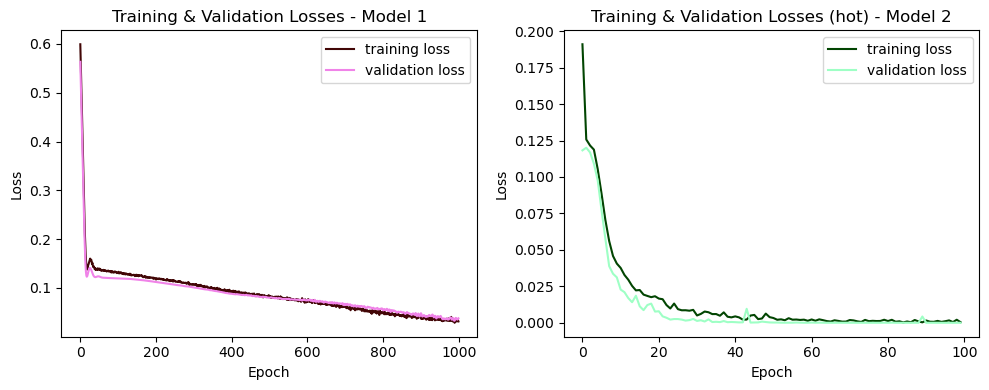

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: losses
axes[0].plot(losses, label = "training loss", color="#420606")
axes[0].plot(val_loss_num, label = "validation loss", color="#F083E8")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Losses - Model 1")
axes[0].legend()

# Rihgt: losses_hot
axes[1].plot(losses_hot, label = "training loss", color="#024502")
axes[1].plot(val_loss, label = "validation loss", color="#9EFFC5")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training & Validation Losses (hot) - Model 2")
axes[1].legend()

plt.tight_layout()
plt.show()

In the following plot we can see both graphs together for a better visualization and comparison.

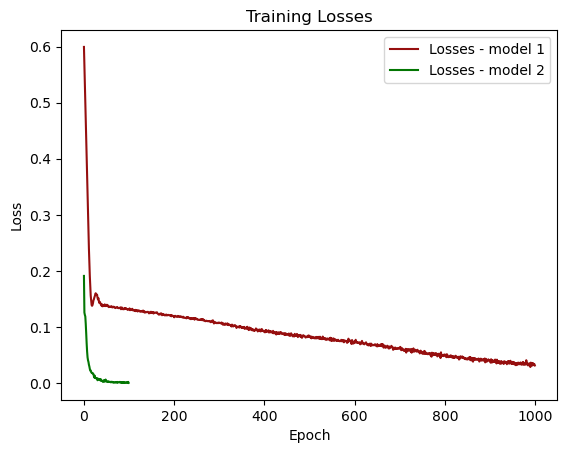

In [25]:
plt.plot(losses, label="Losses - model 1", color="#960F0F")
plt.plot(losses_hot, label="Losses - model 2", color="#037603")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.show()

The following plot shows the losses throughout every batch iteration, demonstrating the fluctuation due to the dropouts used. 

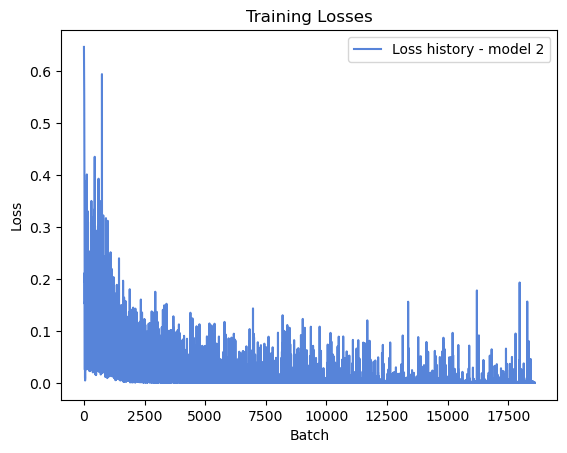

In [26]:
plt.plot(loss_hist_hot, label="Loss history - model 2", color="#0045C6A8")

plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.show()

Now let's take a closer look at the labels that were actually predicted.  
First we need to send the data back to the CPU and convert to numpy to generate some visualizations and computations.  

In [27]:
#sending data back to CPU
y_true_num = y_test_tensor_num.cpu().numpy().astype(int).ravel()
preds_num = preds_num.cpu().numpy().astype(int).ravel()
cm = confusion_matrix(y_true_num, preds_num)

Out of all samples in the test data only a small percentage is label one. This might be the reason, why the model had more trouble predicting label 1 than label 0.

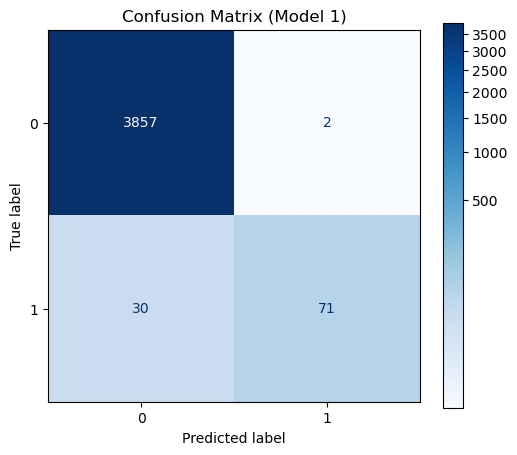

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True, im_kw={"norm": colors.PowerNorm(gamma=0.3)})
plt.title("Confusion Matrix (Model 1)")
plt.show()

_Accuracy_ tells us in how many cases the prediction matches the true label.  
  
_Precision_ describes the amount of true positives.  

_Recall_ shows us how many of the actual positive cases were correctly detected as positive.  
  
And lastly, the _F1_-_score_ combines Precision and Recall and gives a balanced representation of both results.

The numbers show, that the overall Accuracy seems to be quite good for model 1. However, when looking at the recall-value, it shows, that the model misses many samples with label 1.  
In a real world scenario, where the label might indicate a certain disease for example, the model would misdiagnose a good amount of actually positive cases.

In [29]:
accuracy  = accuracy_score(y_true_num, preds_num)
precision = precision_score(y_true_num, preds_num)
recall    = recall_score(y_true_num, preds_num)
f1        = f1_score(y_true_num, preds_num)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

Accuracy : 0.9919191919191919
Precision: 0.9726027397260274
Recall   : 0.7029702970297029
F1-score : 0.8160919540229885


In [30]:
total_cm = cm.sum()
correct_cm = np.trace(cm)
mis_total_cm = total_cm - correct_cm

print(f"Total samples: {total_cm}")
print(f"Correct: {correct_cm}  ({correct_cm/total_cm:.2%})")
print(f"Misclassified: {mis_total_cm}  ({mis_total_cm/total_cm:.2%})")

Total samples: 3960
Correct: 3928  (99.19%)
Misclassified: 32  (0.81%)


The second model managed to get everything correct.

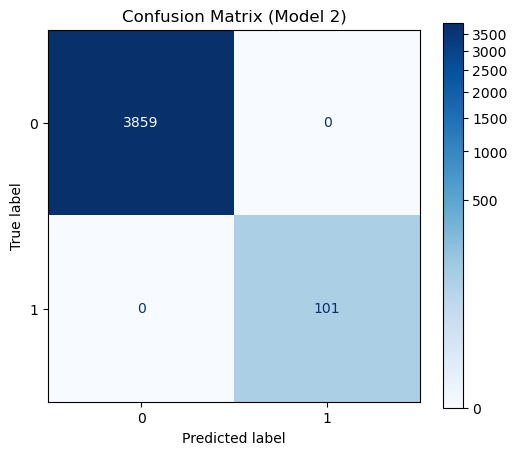

In [31]:
y_true_hot = y_test_tensor_hot.cpu().numpy().astype(int).ravel()
preds_hot = preds_hot.cpu().numpy().astype(int).ravel()

cm_hot = confusion_matrix(y_true_hot, preds_hot)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_hot)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True, im_kw={"norm": colors.PowerNorm(gamma=0.3)})
plt.title("Confusion Matrix (Model 2)")
plt.show()

In [32]:
accuracy_hot  = accuracy_score(y_true_hot, preds_hot)
precision_hot = precision_score(y_true_hot, preds_hot)
recall_hot    = recall_score(y_true_hot, preds_hot)
f1_hot        = f1_score(y_true_hot, preds_hot)

print("Accuracy :", accuracy_hot)
print("Precision:", precision_hot)
print("Recall   :", recall_hot)
print("F1-score :", f1_hot)

Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0


In [33]:
total_cm_hot = cm_hot.sum()
correct_cm_hot = np.trace(cm_hot)
mis_total_cm_hot = total_cm_hot - correct_cm_hot

print(f"Total samples: {total_cm_hot}")
print(f"Correct: {correct_cm_hot}  ({correct_cm_hot/total_cm_hot:.2%})")
print(f"Misclassified: {mis_total_cm_hot}  ({mis_total_cm_hot/total_cm_hot:.2%})")

Total samples: 3960
Correct: 3960  (100.00%)
Misclassified: 0  (0.00%)


## 8 Discussion 
_Provide a short reflection on model behavior and performance._

Both models achieve very low training losses. 
Model 1 has a high accuracy even though it had to compensate for the numeric conversion of the letters.
Due to the small number of samples for label one, the model struggles to predict this class correctly, which is reflected in the low recall value.  

Model 2 had the advantage of learning with the one-hot encoded data and batches.
As a result, the model is able to perfectly predict the outcome.  

We also tested the results for dividing test and train data into equal parts. In this case, the first model showed a much higher error rate while the second model remained the same and was still able to predict 100% correctly.